In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# from celluloid import Camera # getting the camera
import seaborn as sns
import itertools
import os
import shutil
import random
from google.colab import files 
import cv2
import glob
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [5]:
# Experiment Environment Setup
files.upload()
!mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

mkdir: cannot create directory ‘/root/.kaggle’: File exists
covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip covid19-radiography-database.zip 

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [7]:
os.mkdir('dataset')
test_path = '/content/dataset/test'
path  =  '/content/dataset/'
os.mkdir(test_path)
base = '/content/COVID-19_Radiography_Dataset'
paths   = os.listdir(base)

In [8]:
# We are creating the test directories
for k in range(len(paths)):
    if os.path.isdir(os.path.join(base,paths[k])):
        os.mkdir(os.path.join(test_path,paths[k]))

In [9]:
# We are creating our test set
if os.path.isdir(path) is True:
    paths   = os.listdir(base)
    pr =  0.1
    for k in range(len(paths)):
        if os.path.isdir(os.path.join(base,paths[k])):
          # We are moving 2% of the sample dataset to test

          n = np.int(len(os.listdir(os.path.join(base,paths[k]))) * pr)
          for c in random.sample(glob.glob(os.path.join(base,paths[k]+'/'+paths[k]+'*')),n):
            shutil.move(c,os.path.join(test_path,paths[k]))

In [10]:
CLASSES  = os.listdir(test_path) #['Normal', 'Lung_Opacity', 'COVID', 'Viral Pneumonia']
CLASSES

['Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID']

In [11]:
datapath  = '/content/COVID-19_Radiography_Dataset'


In [12]:
#import fastai.. cheat and load everything!
from fastai import *
#import fastai more specific
from fastai.vision import *
from fastai.metrics import *
from pathlib import Path

In [25]:
testpath = '/content/dataset/'

In [74]:
np.random.seed(42)
bs = 32

data = ImageDataBunch.from_folder(datapath, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4,bs=bs).normalize(imagenet_stats)

test = ImageList.from_folder(test_path)

In [75]:
data.classes

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

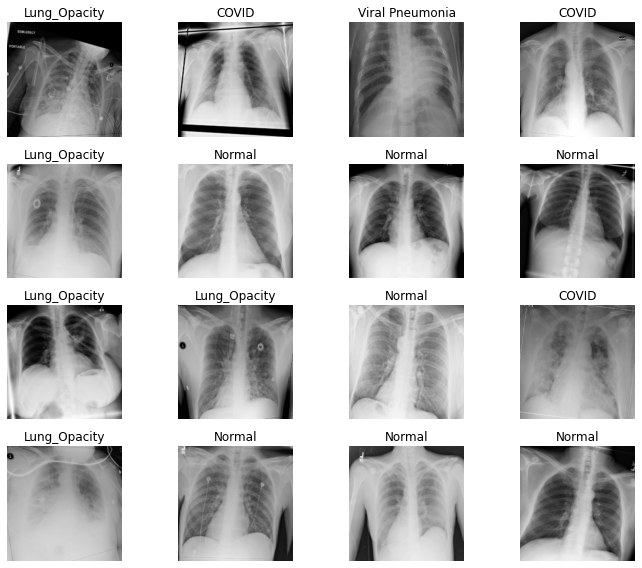

In [76]:
data.show_batch(rows=4, figsize=(10, 8),dpi=300,cmap="rainbow",alpha=1.0)

plt.cm.register_cmap(name='tab20', cmap='rainbow')

In [78]:
from fastai.metrics import error_rate # 1 - accuracy
# learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy,Precision(average='micro'),Recall(average='micro'),FBeta(average='micro')],callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


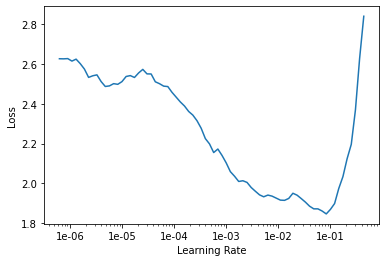

In [79]:
learn.lr_find()
learn.recorder.plot()

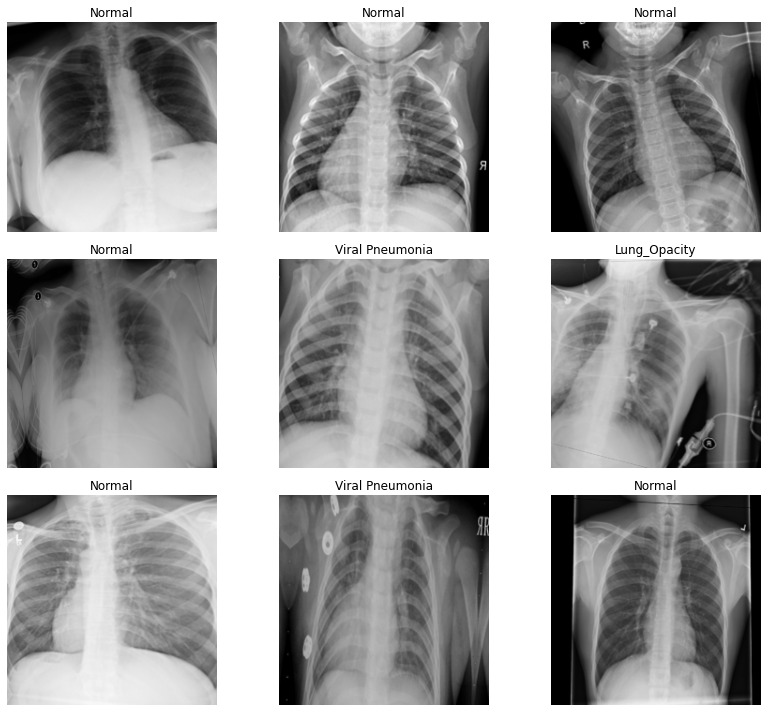

In [43]:
data.show_batch(rows=3, figsize=(12,10))

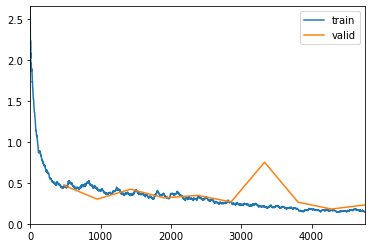

In [80]:
result = learn.fit_one_cycle(10,max_lr=slice(0.003,0.020))

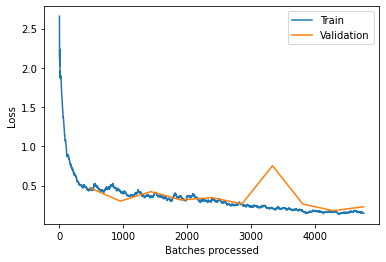

In [81]:
learn.recorder.plot_losses()

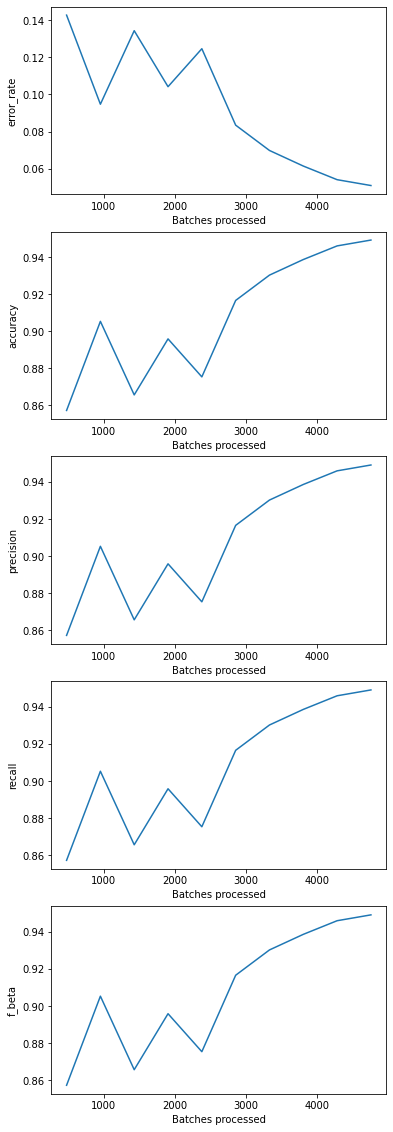

In [82]:
learn.recorder.plot_metrics()


In [83]:
# we save our results weights to use later
learn.save('/content/models/chestxcr-stage-1')

In [46]:
learn.export('/content/models/trained_model50.pkl')

In [84]:
# This gathers the data together for the comparing top losses and confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

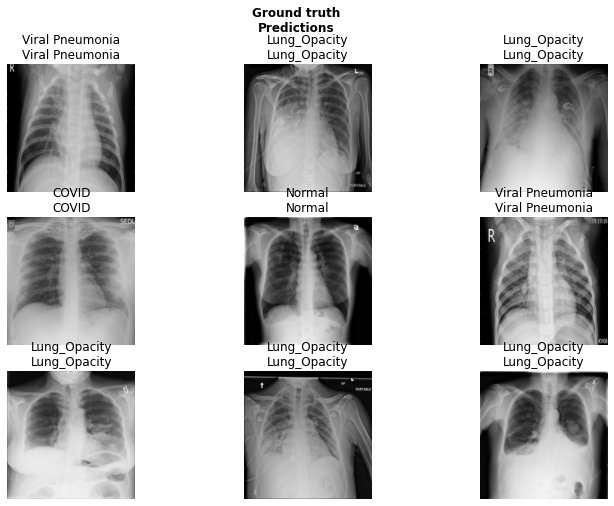

In [85]:
learn.show_results(rows=3, figsize=(12,8),dpi=300)

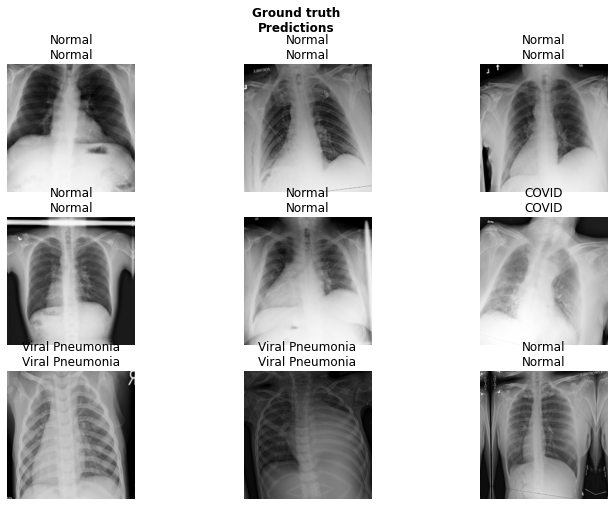

In [89]:
learn.show_results(ds_type=DatasetType.Train, rows=3, figsize=(12,8),dpi=300)

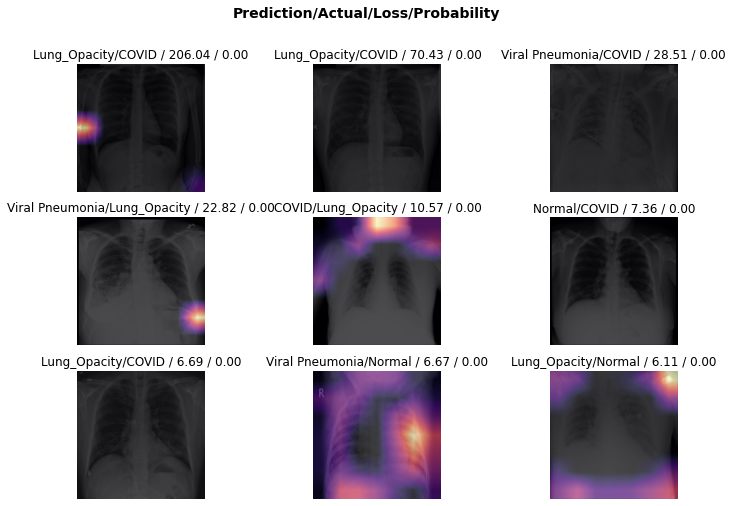

In [90]:
#Lists the top categories
interp.plot_top_losses(9,figsize=(12,8),heatmap=True, alpha=0.7,cmap='magma')

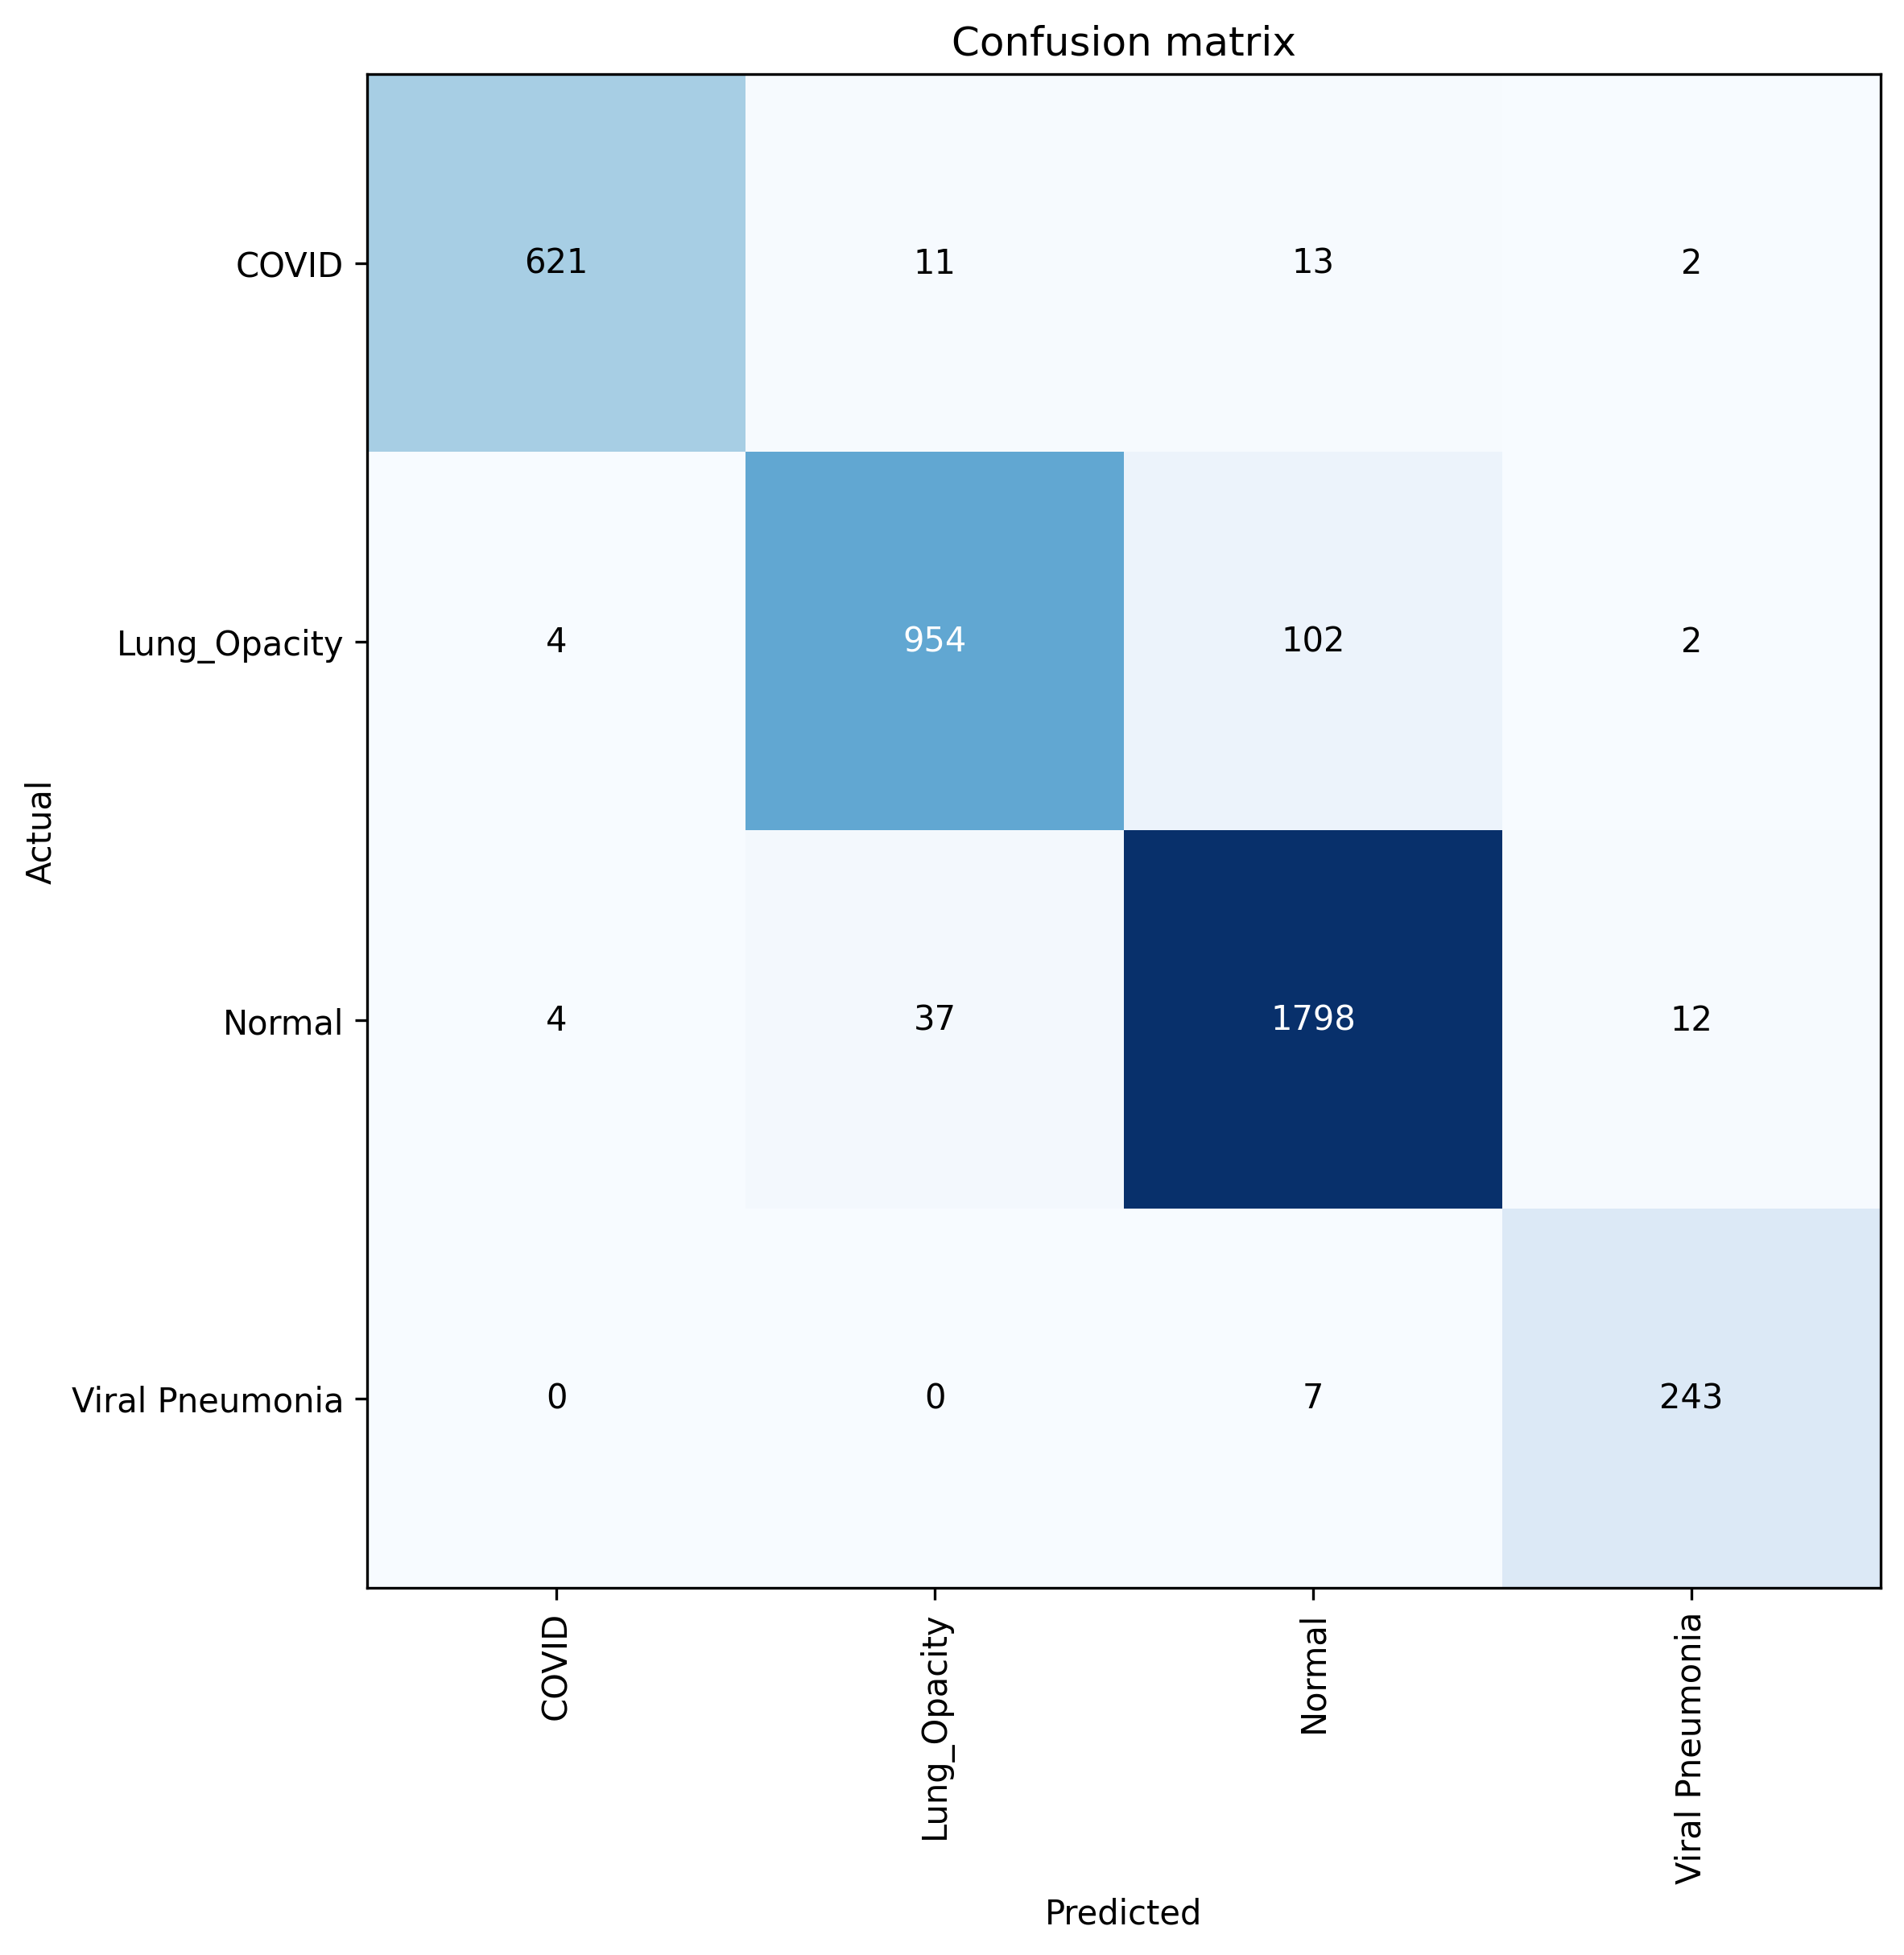

In [91]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(12,8), dpi=300)



```
# This is formatted as code
```

##Stage 2 Data Augmentation Techniques


In [92]:
np.random.seed(42)
bs = 32
tfms =  get_transforms(flip_vert=True, max_rotate=0.0, max_zoom=1.05, max_lighting=0.0, max_warp=0.0)
data =  ImageDataBunch.from_folder(datapath,train='.',valid_pct=0.2,ds_tfms=tfms,size=224,bs=bs,num_workers=4)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (15240 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Lung_Opacity,Lung_Opacity,Lung_Opacity,Lung_Opacity,Lung_Opacity
Path: /content/COVID-19_Radiography_Dataset;

Valid: LabelList (3810 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Viral Pneumonia,Lung_Opacity,Lung_Opacity,COVID,Normal
Path: /content/COVID-19_Radiography_Dataset;

Test: None

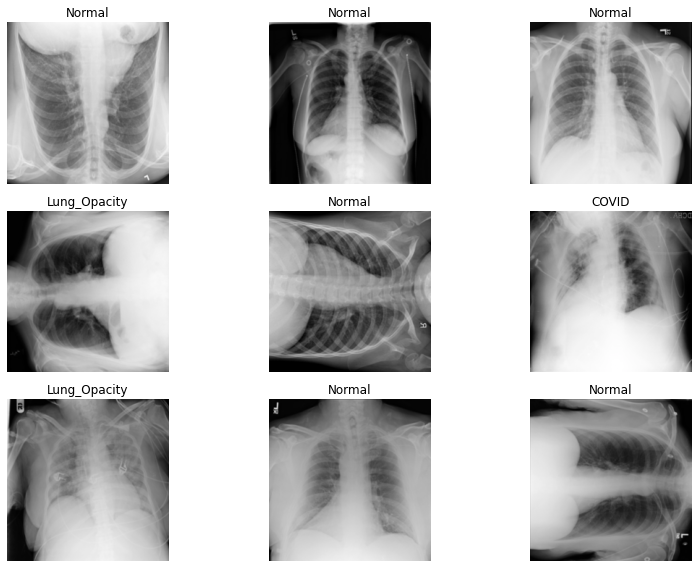

In [93]:
#show some of them with labels
data.show_batch(rows=3, figsize=(12,8),cmap='magma')


In [94]:
# learn = load_learner('/content/models/','trained_model50.pkl')
learn.data = data
learn.load('/content/models/chestxcr-stage-1')
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


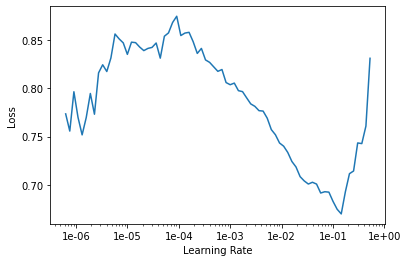

In [95]:
learn.recorder.plot()

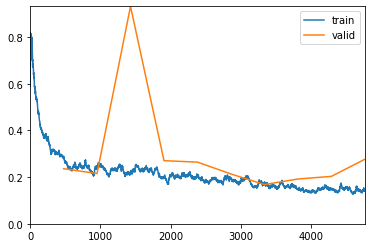

In [96]:
# # We are going to run this 4 times
# result = learn.fit_one_cycle(4,max_lr=slice(0.003,0.020))

result2 = learn.fit_one_cycle(10,max_lr=slice(0.003,0.020/10))

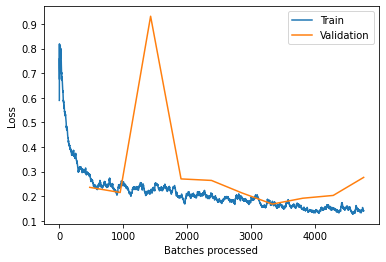

In [97]:
learn.recorder.plot_losses()

In [99]:
# we save our results weights to use later
learn.save('brainmri-stage-2')

##Stage 2 Result Interpretation

In [100]:
# This gathers the data together for the comparing top losses and confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

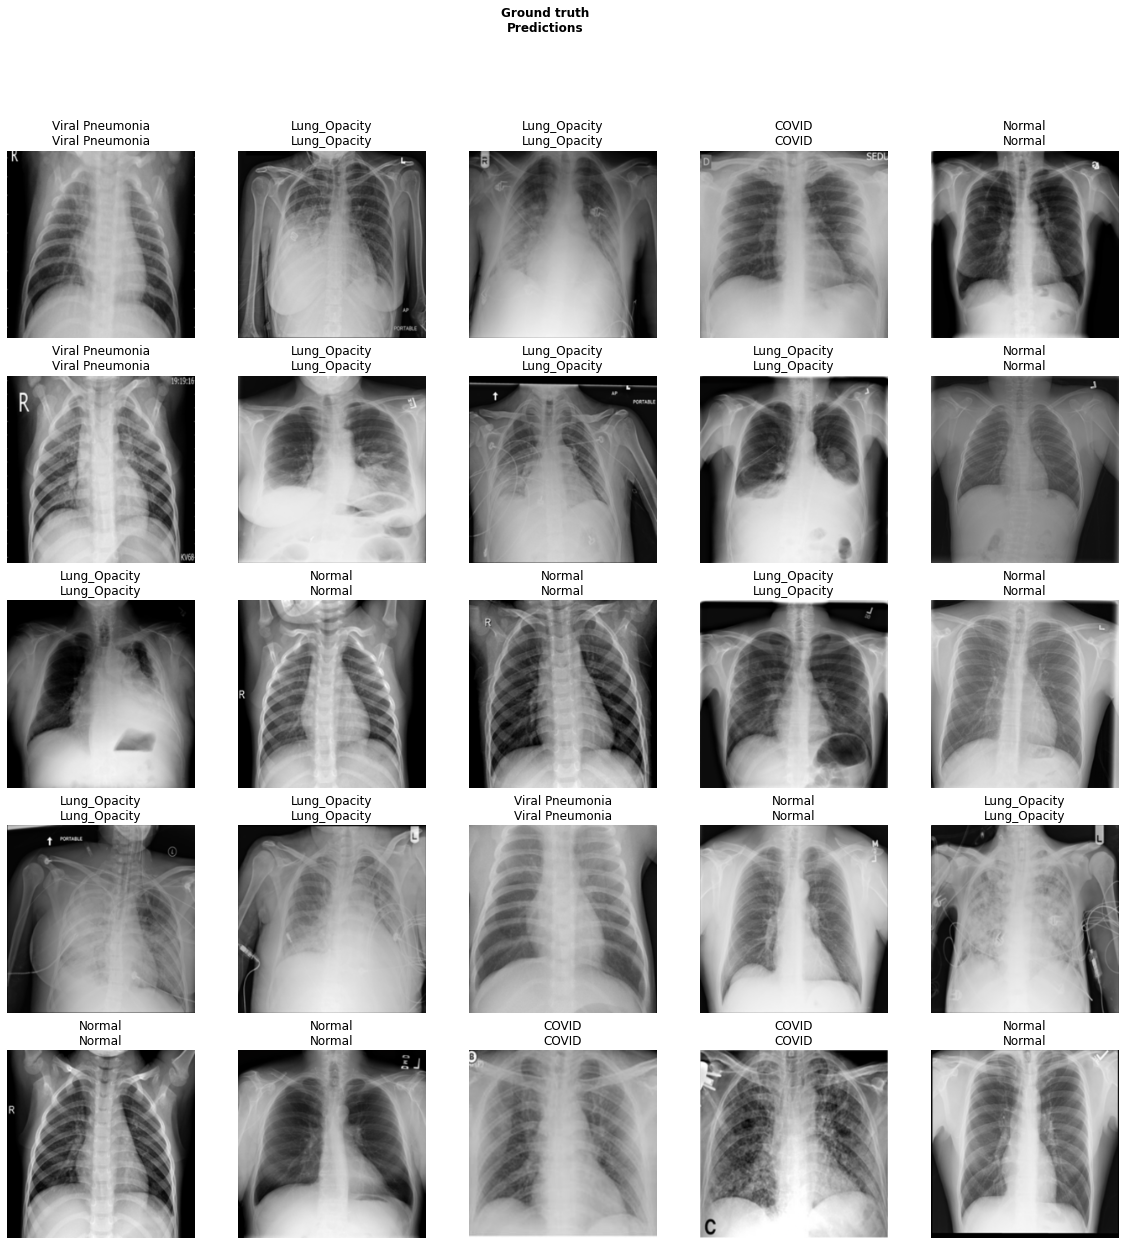

In [101]:
learn.show_results()

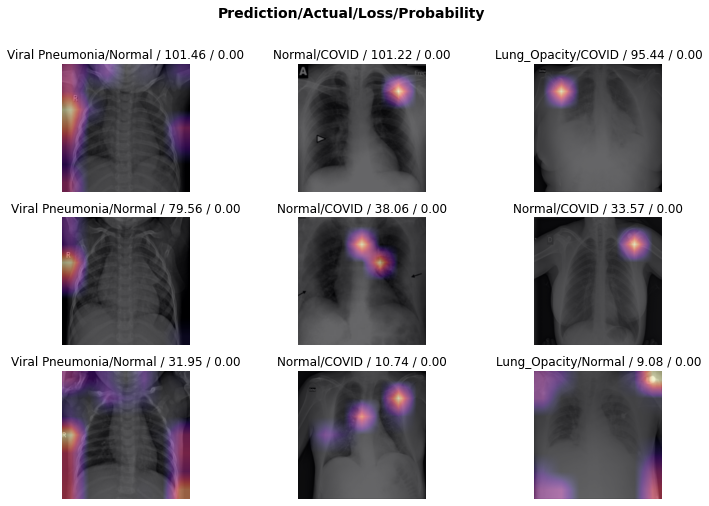

In [103]:
#Lists the top categories
interp.plot_top_losses(9,figsize=(12,8),heatmap=True,cmap='magma')

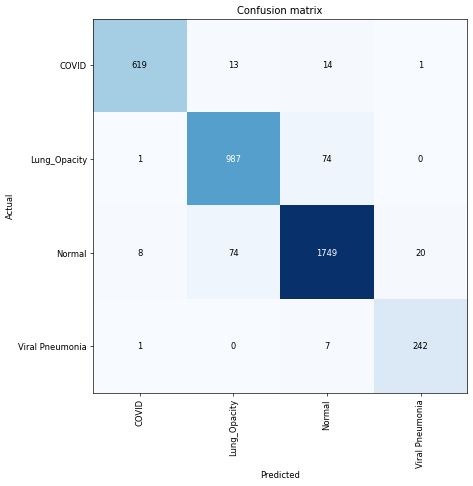

In [104]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(12,8), dpi=60)

In [105]:
#most confused
interp.most_confused(min_val=2)

[('Lung_Opacity', 'Normal', 74),
 ('Normal', 'Lung_Opacity', 74),
 ('Normal', 'Viral Pneumonia', 20),
 ('COVID', 'Normal', 14),
 ('COVID', 'Lung_Opacity', 13),
 ('Normal', 'COVID', 8),
 ('Viral Pneumonia', 'Normal', 7)]

## Stage 3 Augmentation and Unfreezing

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


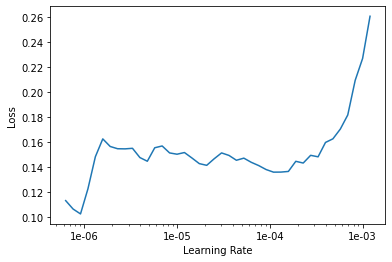

In [106]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

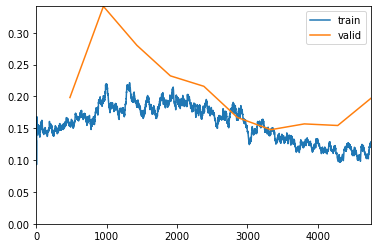

In [107]:
learn.fit_one_cycle(10,max_lr=slice(1e-6,0.020/5))

##Stage 3 Result Interpretation

In [108]:
# This gathers the data together for the comparing top losses and confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

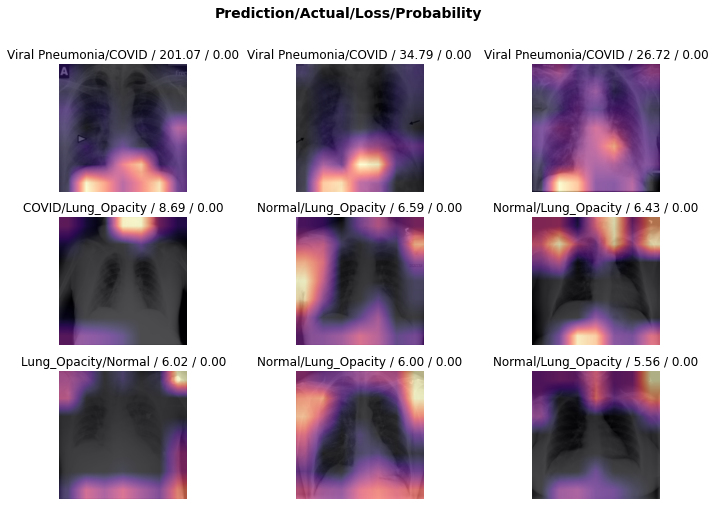

In [112]:
#Lists the top categories
interp.plot_top_losses(9,figsize=(12,8),heatmap=True, alpha=0.7,cmap='magma')

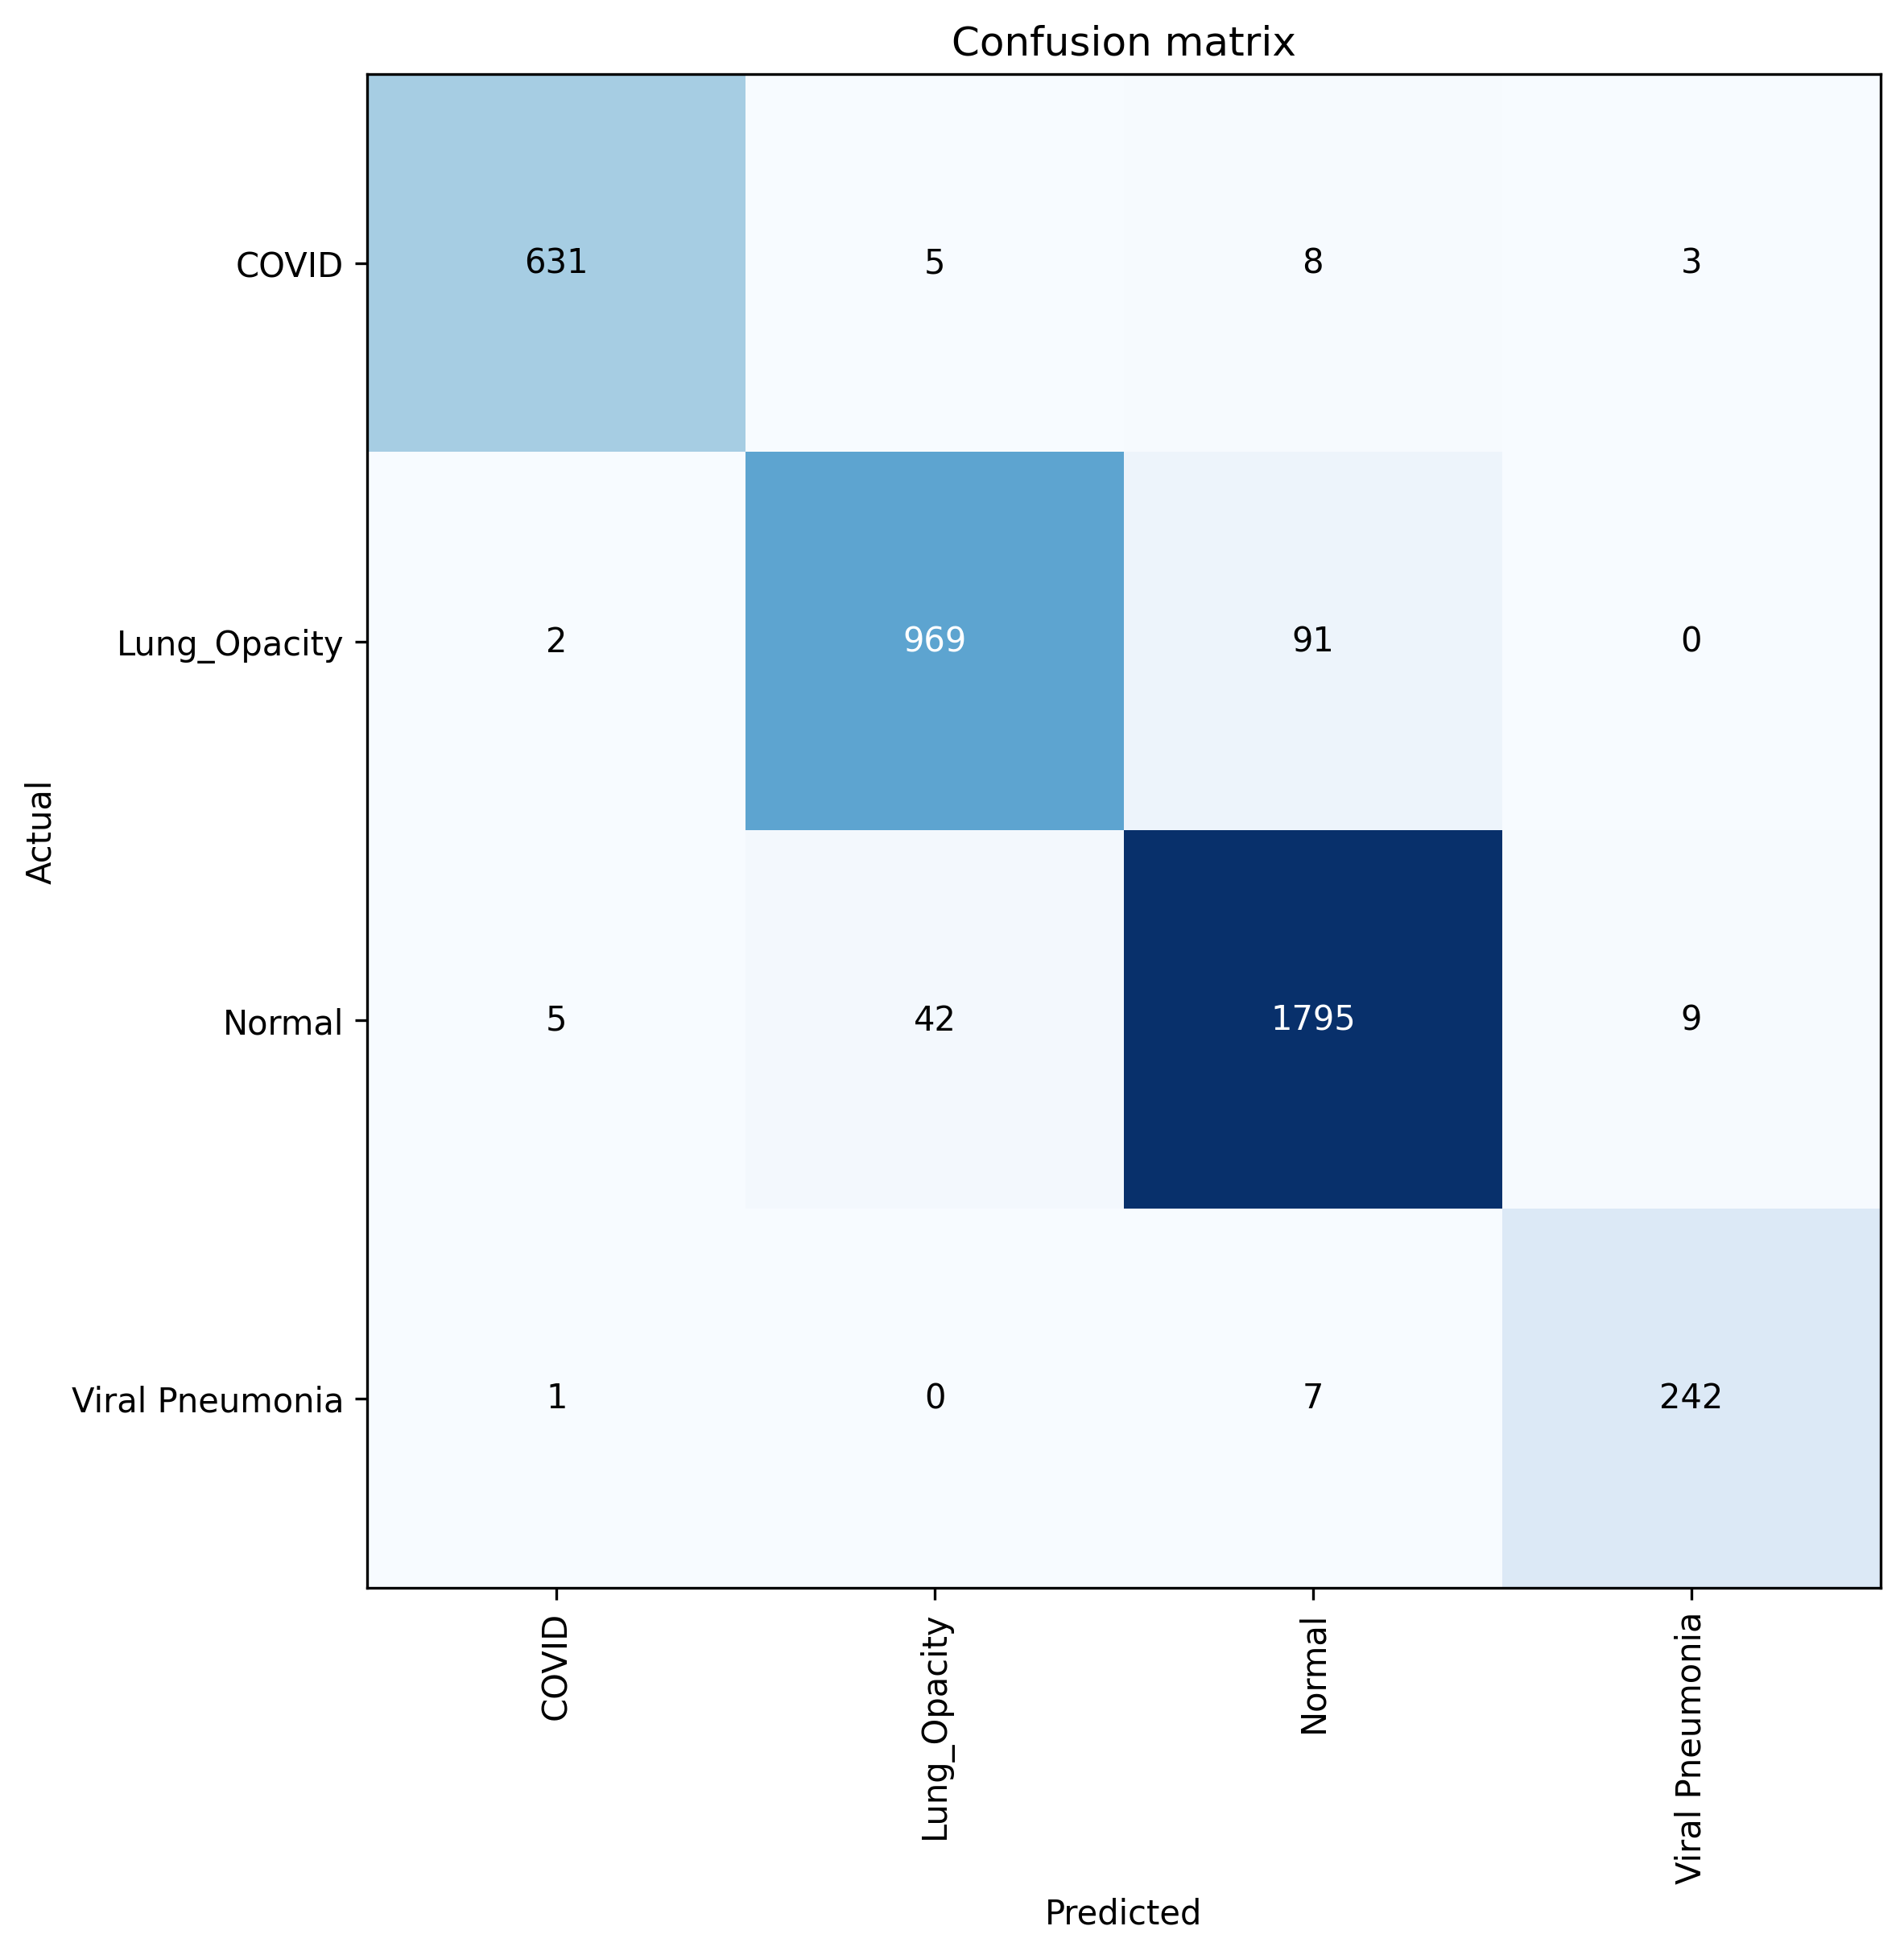

In [113]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(12,8), dpi=300)

In [114]:
learn.export('/content/models/resnet50-final.pkl')


In [115]:
# we save our results weights to use later
learn.save('/content/models/chestxcr-stage-3')

In [132]:
data =  ImageDataBunch.from_folder(datapath,train='.',valid_pct=0.2,test=test_path,ds_tfms=tfms,size=224,bs=bs,num_workers=4).normalize(imagenet_stats)

In [133]:
res  = learn.validate(data.test_dl)

In [131]:
loss,acc  = res[0],res[1]
print(f'Loss: {loss}, Accuracy: {acc*100} %')

Loss: 10.82939624786377, Accuracy: 83.0260009765625 %


In [134]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

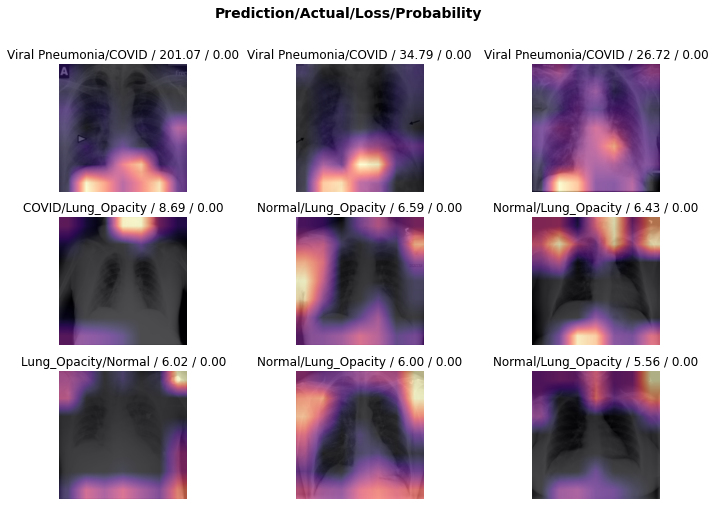

In [135]:
#Lists the top categories
interp.plot_top_losses(9,figsize=(12,8),heatmap=True, alpha=0.7,cmap='magma')

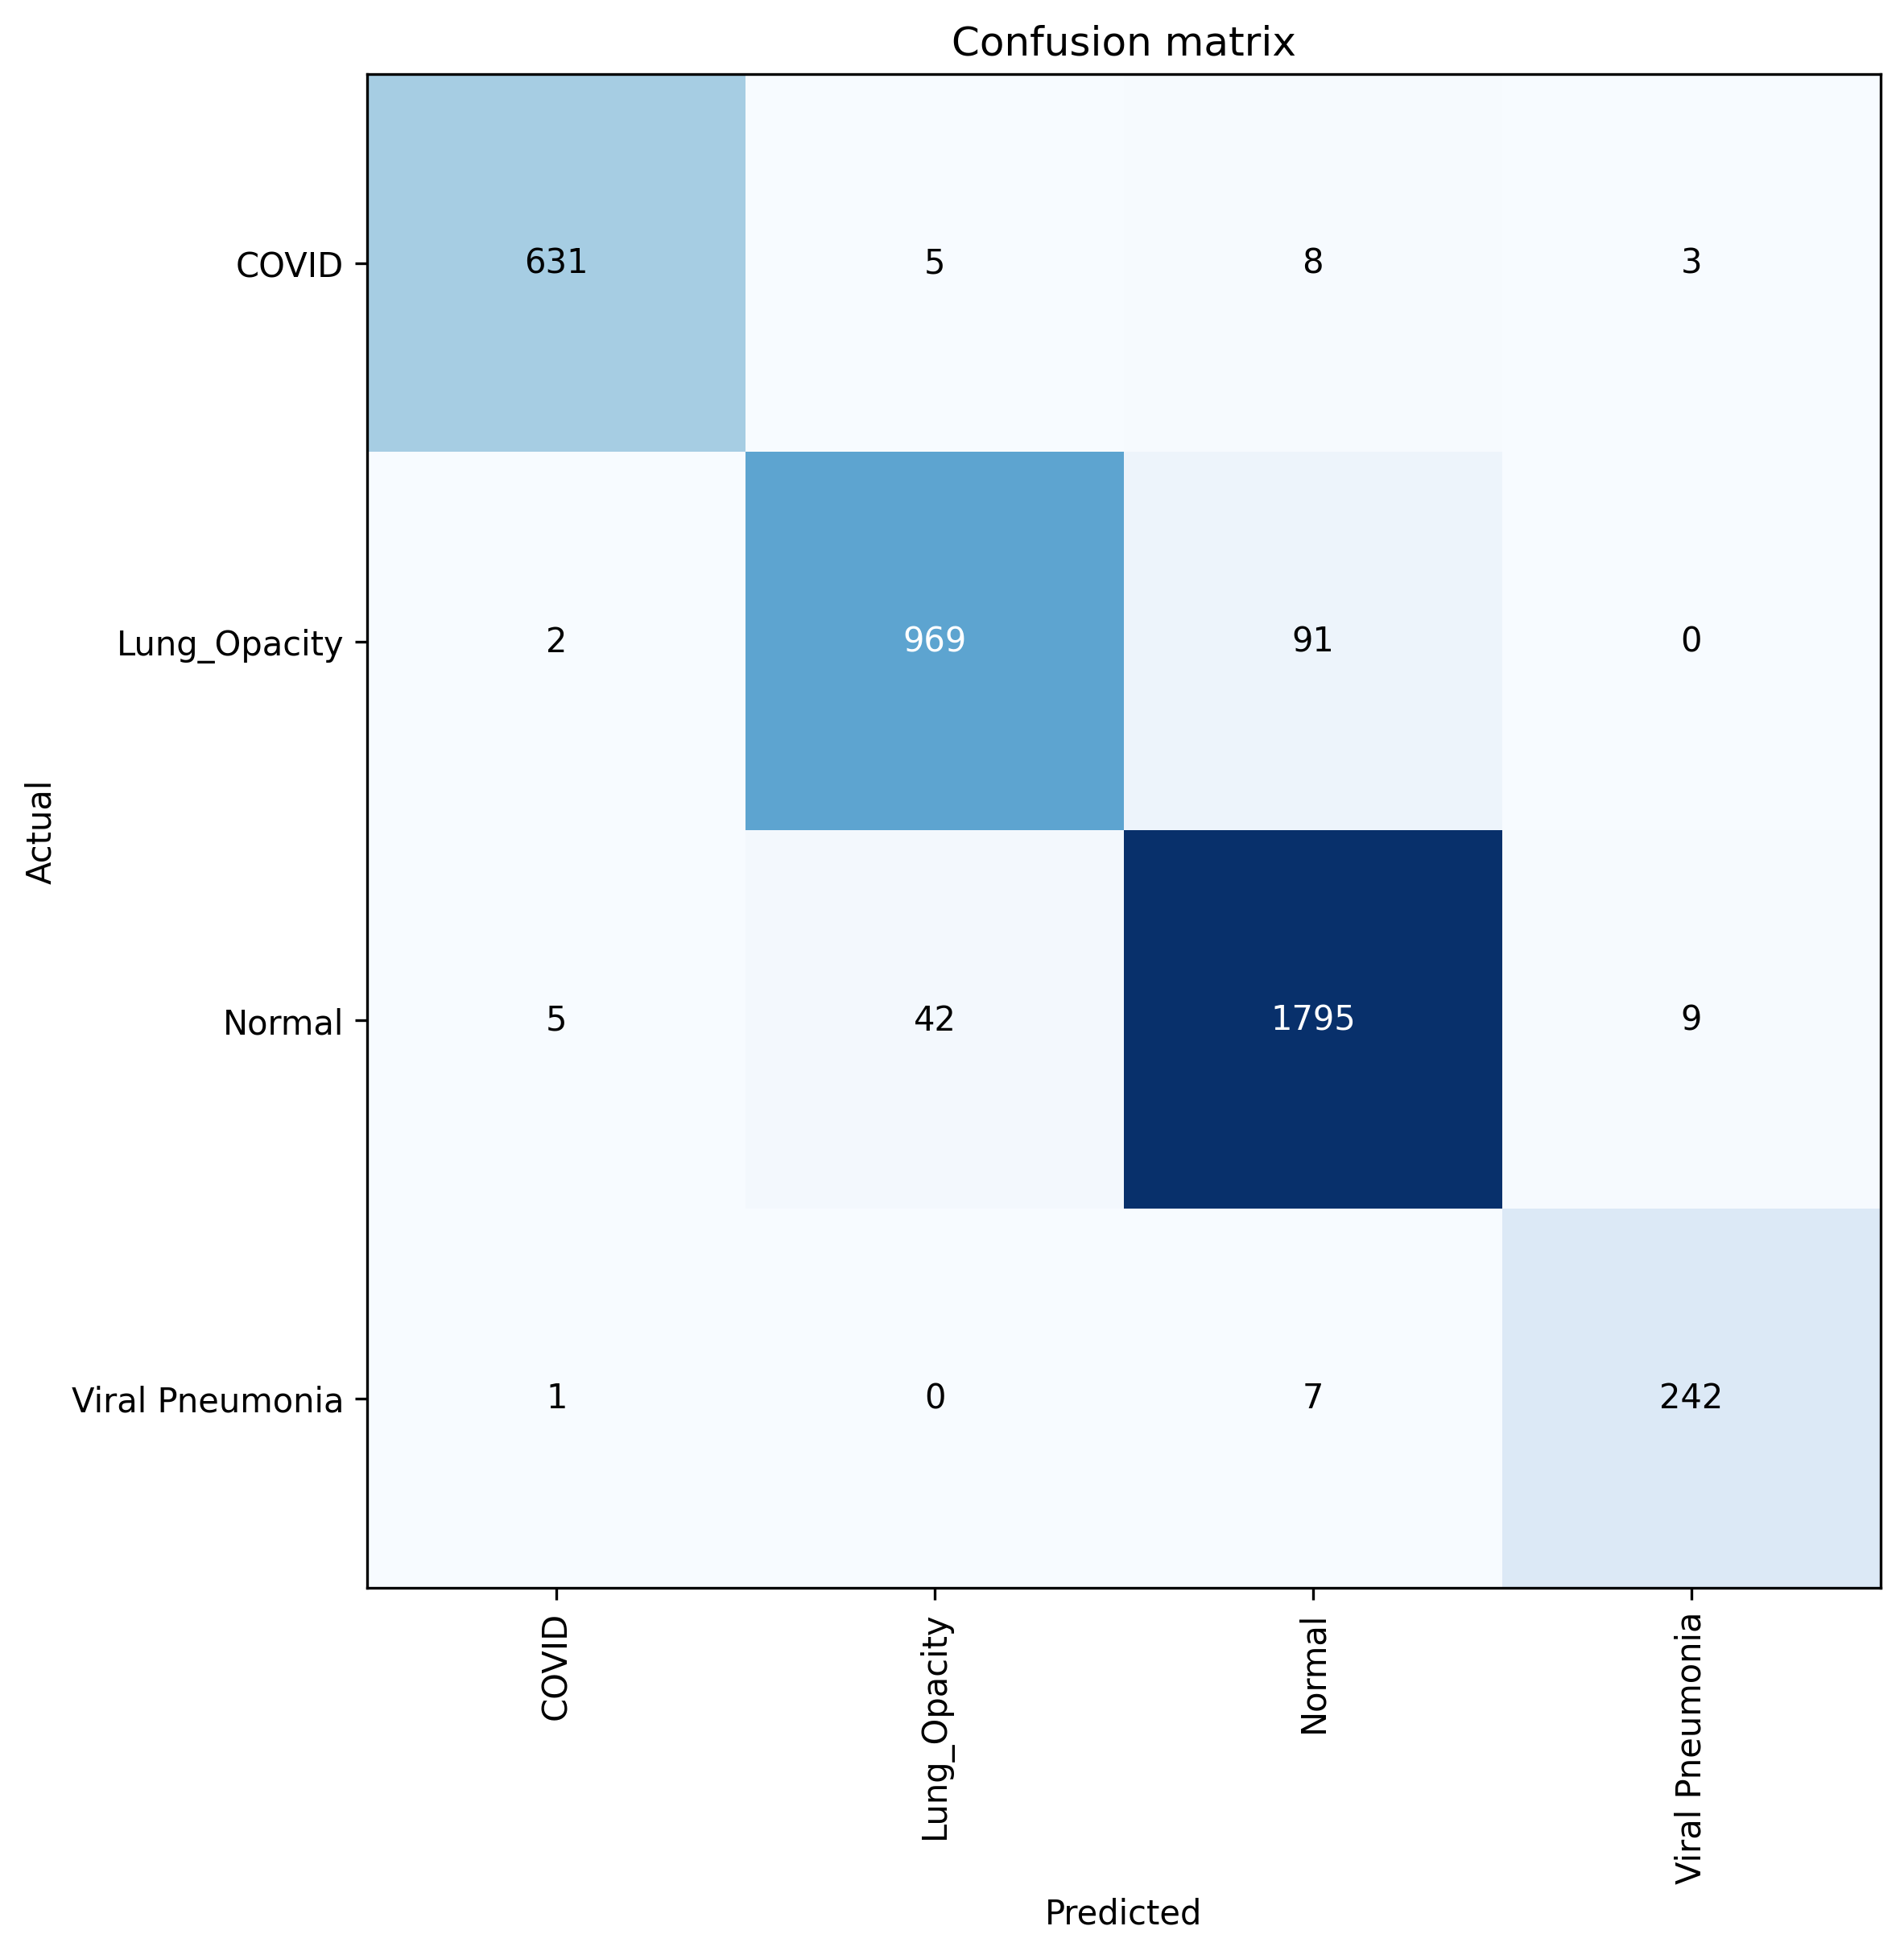

In [136]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(12,8), dpi=300)

In [144]:
pred_fwd,lbl_fwd = learn.get_preds(ds_type=data.test_dl) 
accuracy(pred_fwd, lbl_fwd)

tensor(0.9680)

In [145]:
acc = learn.validate(data.test_dl)[1]
acc

tensor(0.8303)

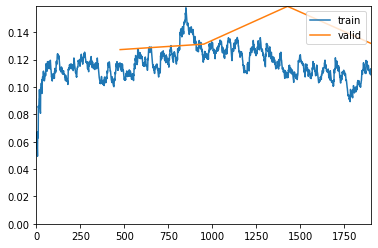

In [146]:
learn.fit_one_cycle(4,max_lr=slice(1e-6,0.020/5))

In [147]:
pred_fwd,lbl_fwd = learn.get_preds(ds_type=data.test_dl) 
accuracy(pred_fwd, lbl_fwd)

tensor(0.9707)

In [148]:
lbl_fwd

tensor([1, 1, 1,  ..., 0, 0, 0])

In [152]:
print(np.argmax(pred_fwd))

tensor(85)


In [153]:
lbl_fwd

tensor([1, 1, 1,  ..., 0, 0, 0])

In [154]:
acc = learn.validate(data.test_dl)[1]
acc

tensor(0.8293)